### Assignment - 1

#### 1. Load and Inspect the CMAPSS Dataset
Task:
- Write Python code to load the raw `train_FD001.txt` dataset for CMAPSS using Pandas, assign appropriate column names, and display the shape, data types, and first 5 rows of the DataFrame.
- Expected Output: DataFrame shape, info, and sample rows.

Use the link to download the dataset:
https://data.nasa.gov/dataset/cmapss-jet-engine-simulated-data

In [12]:
import pandas as pd
column_names = [
    'unit_number', 'time_in_cycles',
    'operational_setting_1', 'operational_setting_2', 'operational_setting_3'
] + [f'sensor_{i}' for i in range(1, 22)]
df = pd.read_csv("train_FD001.txt", sep=" ", header=None)
df.dropna(axis=1, how='all', inplace=True)  
df.columns = column_names
print(" DataFrame Shape:", df.shape)
print("\n Data Types and Non-Null Info:")
print(df.info())
print("\nFirst 5 Rows:")
print(df.head())


 DataFrame Shape: (20631, 26)

 Data Types and Non-Null Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   unit_number            20631 non-null  int64  
 1   time_in_cycles         20631 non-null  int64  
 2   operational_setting_1  20631 non-null  float64
 3   operational_setting_2  20631 non-null  float64
 4   operational_setting_3  20631 non-null  float64
 5   sensor_1               20631 non-null  float64
 6   sensor_2               20631 non-null  float64
 7   sensor_3               20631 non-null  float64
 8   sensor_4               20631 non-null  float64
 9   sensor_5               20631 non-null  float64
 10  sensor_6               20631 non-null  float64
 11  sensor_7               20631 non-null  float64
 12  sensor_8               20631 non-null  float64
 13  sensor_9               20631 non-null  float

#### 2. Visualize Sensor Distributions and Identify Missing Values
Task:
- Using the loaded dataset (or the cleaned version), visualize the distribution of values for any three sensor columns with histograms, and check for missing values in all columns.
- Expected Output: Three histogram plots and a summary/report on missing values per column.

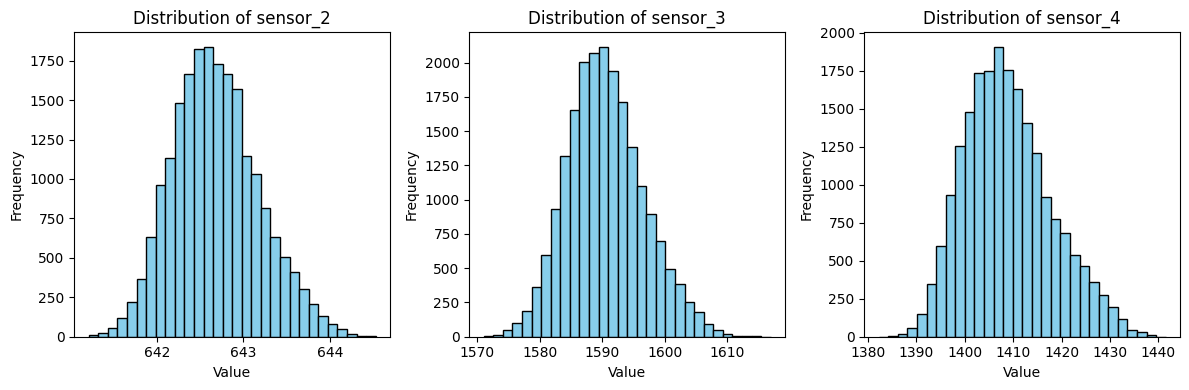

✅ Missing Values Summary:
No missing values found!


In [11]:
import matplotlib.pyplot as plt
sensors_to_plot = ['sensor_2', 'sensor_3', 'sensor_4']

plt.figure(figsize=(12, 4))

for i, sensor in enumerate(sensors_to_plot, 1):
    plt.subplot(1, 3, i)
    plt.hist(df[sensor], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {sensor}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
missing_summary = df.isnull().sum()
print("✅ Missing Values Summary:")
print(missing_summary[missing_summary > 0] if missing_summary.sum() > 0 else "No missing values found!")


#### 3. Feature Engineering – Aggregation and Rolling Statistics
Task:
- For a selected sensor (e.g., `sensor_2`), compute and append to the DataFrame:
  - The mean and standard deviation of `sensor_2` by each `engine_id`

  - The rolling mean (window size=5) for each engine’s `sensor_2` readings
- Expected Output: Show a few sample rows with these new features.

In [13]:
import pandas as pd
agg_stats = df.groupby('unit_number')['sensor_2'].agg(['mean', 'std']).reset_index()
agg_stats.rename(columns={'mean': 'sensor_2_mean', 'std': 'sensor_2_std'}, inplace=True)
df = pd.merge(df, agg_stats, on='unit_number', how='left')
df['sensor_2_roll_mean'] = df.groupby('unit_number')['sensor_2'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True)
print(" Sample rows with new features added:")
print(df[['unit_number', 'time_in_cycles', 'sensor_2', 'sensor_2_mean', 'sensor_2_std', 'sensor_2_roll_mean']].head(10))


 Sample rows with new features added:
   unit_number  time_in_cycles  sensor_2  sensor_2_mean  sensor_2_std  \
0            1               1    641.82     642.621042      0.486795   
1            1               2    642.15     642.621042      0.486795   
2            1               3    642.35     642.621042      0.486795   
3            1               4    642.35     642.621042      0.486795   
4            1               5    642.37     642.621042      0.486795   
5            1               6    642.10     642.621042      0.486795   
6            1               7    642.48     642.621042      0.486795   
7            1               8    642.56     642.621042      0.486795   
8            1               9    642.12     642.621042      0.486795   
9            1              10    641.71     642.621042      0.486795   

   sensor_2_roll_mean  
0          641.820000  
1          641.985000  
2          642.106667  
3          642.167500  
4          642.208000  
5          642

#### 4. Data Normalization
Task:
- Normalize all sensor columns in the DataFrame using `StandardScaler` from `scikit-learn` (zero mean, unit variance) and create a new DataFrame, maintaining the original `engine_id` and `cycle` columns.
- Expected Output: Head of the normalized DataFrame and a check that means are close to zero, std are close to one.

In [15]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
sensor_cols = [col for col in df.columns if col.startswith('sensor_')]
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df[sensor_cols])
df_normalized = pd.DataFrame(scaled_values, columns=sensor_cols)
df_normalized.insert(0, 'unit_number', df['unit_number'])
df_normalized.insert(1, 'time_in_cycles', df['time_in_cycles'])
print("Head of Normalized DataFrame:")
print(df_normalized.head())
print("\nMean of each sensor column (should be close to 0):")
print(df_normalized[sensor_cols].mean().round(3))

print("\nStd of each sensor column (should be close to 1):")
print(df_normalized[sensor_cols].std().round(3))


Head of Normalized DataFrame:
   unit_number  time_in_cycles  sensor_1  sensor_2  sensor_3  sensor_4  \
0            1               1       0.0 -1.721725 -0.134255 -0.925936   
1            1               2       0.0 -1.061780  0.211528 -0.643726   
2            1               3       0.0 -0.661813 -0.413166 -0.525953   
3            1               4       0.0 -0.661813 -1.261314 -0.784831   
4            1               5       0.0 -0.621816 -1.251528 -0.301518   

       sensor_5  sensor_6  sensor_7  sensor_8  ...  sensor_15     sensor_16  \
0 -1.776357e-15  0.141683  1.121141 -0.516338  ...  -0.603816 -1.387779e-17   
1 -1.776357e-15  0.141683  0.431930 -0.798093  ...  -0.275852 -1.387779e-17   
2 -1.776357e-15  0.141683  1.008155 -0.234584  ...  -0.649144 -1.387779e-17   
3 -1.776357e-15  0.141683  1.222827  0.188048  ...  -1.971665 -1.387779e-17   
4 -1.776357e-15  0.141683  0.714393 -0.516338  ...  -0.339845 -1.387779e-17   

   sensor_17  sensor_18  sensor_19  sensor_20  sen

#### 5. Rolling Window Sequence Generation
Task:
- Write a function to generate rolling window sequences of length 30 for the sensors of each engine. Save the resulting 3D NumPy array (num_sequences, window_size, num_features), and save the corresponding engine_id and cycle identifier lists as CSV files. Print the shape of the resulting sequence array and contents of the first entry.
- Expected Output: Array shape, example content, and confirmation of successful file saves.